# LSTM

In [106]:
# Google Colab
from google.colab import drive
import os

# General
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Scikit-Learn
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import confusion_matrix, mean_squared_error, mean_absolute_error, mean_absolute_error

# Keras, Tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout 

## Goole Colab Setup

In [107]:
# Mount Google Drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [108]:
# Get the current working directory
print(os.getcwd())

/content


In [109]:
# Drive path is the path where I upload the ETFs history file
drive_path = '/gdrive/MyDrive/Capstone_Project/REIT_ETFs.csv'

# Expect to move the file into the local path
local_path = '/content'

In [110]:
# Copy the file in drive path
!cp '{drive_path}' .

# Change the file from drive path to the local path
os.chdir(local_path)

## Preprocesing

In [111]:
data = pd.read_csv('/content/REIT_ETFs.csv')
data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker
0,2004-09-29,23.794544,23.861371,23.789772,23.794544,205800,0.0,0.0,VNQ
1,2004-09-30,23.866143,24.023660,23.861370,23.985474,27900,0.0,0.0,VNQ
2,2004-10-01,24.033207,24.462799,23.985476,24.429386,129800,0.0,0.0,VNQ
3,2004-10-04,24.529629,24.606000,24.529629,24.534403,8100,0.0,0.0,VNQ
4,2004-10-05,24.534403,24.582135,24.510535,24.529629,11900,0.0,0.0,VNQ
...,...,...,...,...,...,...,...,...,...
53434,2021-06-17,9.280000,9.290000,9.220000,9.220000,5200,0.0,0.0,REK
53435,2021-06-18,9.330000,9.370000,9.270000,9.370000,22800,0.0,0.0,REK
53436,2021-06-21,9.320000,9.320000,9.170000,9.170000,22900,0.0,0.0,REK
53437,2021-06-22,9.160000,9.230000,9.160000,9.220000,6200,0.0,0.0,REK


In [112]:
vnq = data.loc[data['Ticker'] == "VNQ"]

In [113]:
# Convert Date column to datetime64 type
vnq['Date'] = pd.to_datetime(vnq['Date'])

# Set index to a datetime index
vnq.set_index('Date', inplace=True)

# Check
display(vnq.head())

print(vnq.index.inferred_type == "datetime64")

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker
Date,,,,,,,,
2004-09-29,23.794544,23.861371,23.789772,23.794544,205800,0.0,0.0,VNQ
2004-09-30,23.866143,24.023660,23.861370,23.985474,27900,0.0,0.0,VNQ
2004-10-01,24.033207,24.462799,23.985476,24.429386,129800,0.0,0.0,VNQ
2004-10-04,24.529629,24.606000,24.529629,24.534403,8100,0.0,0.0,VNQ
2004-10-05,24.534403,24.582135,24.510535,24.529629,11900,0.0,0.0,VNQ


True


In [ ]:
# Drop unnecessary columns
# vnq.drop(columns=vnq.columns[-3:].tolist(), inplace=True)

In [114]:
train = vnq['Close'].iloc[:-253]
test = vnq['Close'].iloc[-253:]

In [115]:
# Scale the data
scaler = MinMaxScaler()

train_scale = scaler.fit_transform(train.values.reshape(-1,1))
test_scale = scaler.transform(test.values.reshape(-1,1))

In [116]:
train_scale.shape

(3960, 1)

In [117]:
def train_test_split (series, timestep):
    '''
    series: train or test set
    
    timestep: use n days to predict the next preceding day's price
    '''
    
    train_part, test_part = [], []
    
    for i in range(len(series)-timestep-1):
         
        train_part.append(series[i:(i+timestep)])

        test_part.append(series[i+timestep])


    return np.array(train_part), np.array(test_part)

In [118]:
X_train, y_train = train_test_split(train_scale, timestep=22)
X_test, y_test = train_test_split(test_scale, timestep=22)

In [119]:
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
 
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (3937, 22, 1)
y_train shape:  (3937, 1)
X_test shape:  (230, 22, 1)
y_test shape:  (230, 1)


https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/LSTM

In [121]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1:])))
model.add(LSTM(50))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [122]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 22, 50)            10400     
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [123]:
model.fit(X_train, y_train, batch_size=1, epochs=1)

3937/3937 [==============================] - 48s 11ms/step - loss: 8.3122e-04


In [124]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [125]:
y_train_inv = scaler.inverse_transform(y_train_pred)
y_test_inv = scaler.inverse_transform(y_test_pred)

In [128]:
print("MSE of train: ", mean_squared_error(y_train, y_train_pred))
print("MSE of test: ", mean_squared_error(y_test, y_test_pred))

MSE of train:  0.00023992367924560783
MSE of test:  0.0002817367753101771


In [139]:
y_test_inv.shape

(230, 1)

In [142]:
test.shape

(253,)

In [143]:
test

Date
2020-06-23     76.604248
2020-06-24     74.421883
2020-06-25     75.372398
2020-06-26     73.925735
2020-06-29     75.352982
                 ...    
2021-06-17    103.550003
2021-06-18    101.790001
2021-06-21    103.889999
2021-06-22    103.349998
2021-06-23    103.169998
Name: Close, Length: 253, dtype: float64

In [147]:
test_index = test.index[23:]

In [148]:
pred_df = pd.DataFrame(index=test_index,
                       columns=['predicted'])
pred_df['predicted'] = y_test_inv

In [149]:
pred_df

,predicted
Date,
2020-07-27,77.033897
2020-07-28,77.082634
2020-07-29,77.237198
2020-07-30,77.821548
2020-07-31,78.877258
...,...
2021-06-17,105.916534
2021-06-18,105.187935
2021-06-21,104.433807


In [154]:
test.iloc[23:].index

DatetimeIndex(['2020-07-27', '2020-07-28', '2020-07-29', '2020-07-30',
               '2020-07-31', '2020-08-03', '2020-08-04', '2020-08-05',
               '2020-08-06', '2020-08-07',
               ...
               '2021-06-10', '2021-06-11', '2021-06-14', '2021-06-15',
               '2021-06-16', '2021-06-17', '2021-06-18', '2021-06-21',
               '2021-06-22', '2021-06-23'],
              dtype='datetime64[ns]', name='Date', length=230, freq=None)

In [155]:
actual_df = pd.DataFrame(index=test.iloc[23:].index,
                         columns=['actual'])
actual_df['actual'] = test.iloc[23:].values

In [156]:
actual_df

,actual
Date,
2020-07-27,76.644310
2020-07-28,78.168648
2020-07-29,79.683281
2020-07-30,79.168701
2020-07-31,79.023056
...,...
2021-06-17,103.550003
2021-06-18,101.790001
2021-06-21,103.889999


In [162]:
compare_df = pd.concat([actual_df, pred_df], axis=1)

In [163]:
compare_df

,actual,predicted
Date,,
2020-07-27,76.644310,77.033897
2020-07-28,78.168648,77.082634
2020-07-29,79.683281,77.237198
2020-07-30,79.168701,77.821548
2020-07-31,79.023056,78.877258
...,...,...
2021-06-17,103.550003,105.916534
2021-06-18,101.790001,105.187935
2021-06-21,103.889999,104.433807


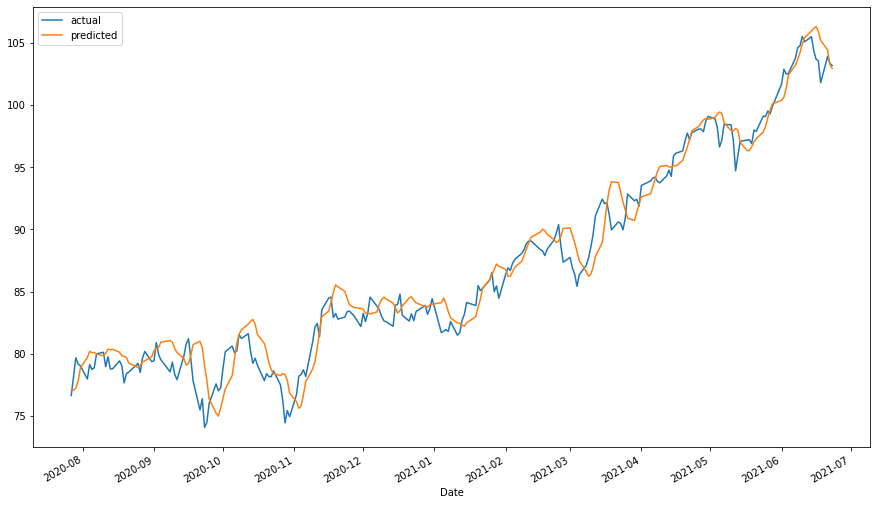

In [168]:
compare_df.plot(figsize=(15,9))